２ノードのグラフィカルモデル でサンプリングEMアルゴリズムを実装する。

In [732]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy
from sklearn.linear_model import LinearRegression,Ridge,Lasso
import math
from sklearn import preprocessing

関数（２ノード）

In [911]:
#尤度の式
def loglikelihood(df,pa_mu,pa_sigma,child_sigma,weight,bias):
    loglikelihood = 0
    for i in range(len(df)):
        loglikelihood += -2*np.log(2*np.pi)/2 - np.log(pa_sigma)/2 -np.log(child_sigma)/2\
        - (df["pa"][i] - pa_mu)**2/(2*pa_sigma) - (df["child"][i] - weight*df["pa"][i] - bias)**2/(2*child_sigma)
    return loglikelihood    

In [912]:
#条件付き分布の解析的な平均、分散。(確認済み)
def conditional_distribution(pa_mu,pa_sigma,weight,child_sigma,child,bias):
    sigma = 1/((1/pa_sigma) + weight*((1/child_sigma)*weight))
    mu = sigma*(weight*(1/child_sigma)*(child-bias) + (1/pa_sigma)*pa_mu)
    
    return [mu,sigma]

In [913]:
#各行の条件付き分布の解析的に求められた平均と分散が格納されたdfを作る。
def conditional_distribution_df_2_node(df,weight,bias):
    mu_list = []
    sigma_list = []
    pa_mu = df["pa"].mean()
    pa_sigma = df["pa"].var()
    child_sigma = df["child"].var()
    
    for i in range(len(df)):
        mu_list.append(conditional_distribution(pa_mu,pa_sigma,weight,child_sigma,df["child"][i],bias)[0])
        sigma_list.append(conditional_distribution(pa_mu,pa_sigma,weight,child_sigma,df["child"][i],bias)[1])
    
    return pd.DataFrame(data=np.array([mu_list,sigma_list]).T,columns=["mu","sigma"])

In [1042]:
#親ノードの条件付き分布の平均と分散を求める式→正しい。（解析的な解と照合）
def conditional_paramators_2_node(weights,df,pa_mu,pa_sigma,child_sigma):
    conditional_mus,conditional_sigmas = [],[]
    for i in range(len(df)):
        sympy.var("x")
        f = -(x - pa_mu)**2/(2*pa_sigma) - (df["child"][i] -weights[0]*x - weights[1])**2/(2*child_sigma)
         #二次項を評価
        condi_sigma_inv = -2*f.expand(x).coeff(x,2)
        #線形項を評価
        condi_mu = f.expand(x).coeff(x,1)/condi_sigma_inv
        condi_sigma = 1/condi_sigma_inv 
    
        conditional_mus.append(condi_mu)
        conditional_sigmas.append(condi_sigma)
    
    return conditional_mus, conditional_sigmas

In [1043]:
#最小二乗法の関数（確認済み）
def LSM(x,y):
    fun = LinearRegression()
    fun.fit(x,y)
    return [fun.coef_.tolist()[0][0],fun.intercept_[0]]#fun.intercept_[0]

In [1044]:
def weights_update(df):# 重みの更新を行う関数。
    w = LSM(df["pa"].values.reshape(-1,1),df["child"].values.reshape(-1,1))
    
    return w

In [1045]:
def update_paramators(df):
    pa_mu = df["pa"].mean()
    pa_sigma = df["pa"].var()
    
    return pa_mu,pa_sigma

In [1171]:
def monte_carlo_EM_2_node(weights,df,num_iter):
    df = df
    pa_mu = df["pa"].mean()
    pa_sigma = df["pa"].var()
    child_sigma = 0.25
    #記録用
    loglikelihood_list = []
    weights_list = []
    intercept_list = []
    mu_list,sigma_list = [],[]
    for h in range(num_iter):
        condi_mus,condi_sigmas = conditional_paramators_2_node(weights,df,pa_mu,pa_sigma,child_sigma)
        #Eステップ
        #サンプリングした値でdataframeの値を更新。
        for i in range(len(df)):
            df["pa"][i] = np.random.normal(condi_mus[i],math.sqrt(condi_sigmas[i]),1)[0]#np.random.normal の引数は平均と標準偏差
        #Mステップ    
        weights = weights_update(df) #重みを更新
        #pa_mu,pa_sigma = update_paramators(df)#平均と分散を更新
        
        loglikelihood_list.append(loglikelihood(df,pa_mu,pa_sigma,child_sigma,weights[0],weights[1]))
        weights_list.append(weights[0])#重みの計測を記録
        intercept_list.append(weights[1])#重みの切片を記録
        mu_list.append(pa_mu)#平均を記録
        sigma_list.append(pa_sigma)#分散を記録
    return  weights_list,intercept_list,mu_list,sigma_list,loglikelihood_list

テストデータを作る。

In [1172]:
pa = np.random.normal(0,1,100)#親ノード　平均０　標準偏差１ P(x)

child = []
for i in range(len(pa)):
    sample = np.random.normal(pa[i]*3 + 2,0.5,1)[0]#標準偏差0.1 分散0.01
    child.append(sample)
    
child = np.array(child)#p(y|x)

data_list = np.array([pa,child]).T
true_test_df1 = pd.DataFrame(data=data_list,columns = ["pa","child"])#真のテストデータ

In [1173]:
test_df = true_test_df1
#test_df["pa"] = np.random.normal(1,1,100)

In [1174]:
weights_list,intercept_list,mu_list,sigma_list,loglikelihood_list =  monte_carlo_EM_2_node([2,1],test_df,200)

Text(0, 0.5, 'likelihood')

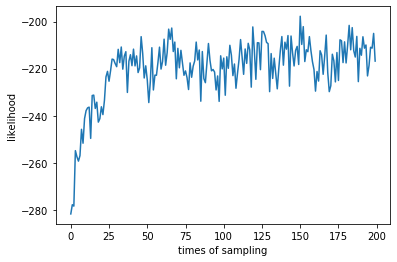

In [1175]:
plt.plot(loglikelihood_list,label="尤度")
plt.xlabel("times of sampling")
plt.ylabel("likelihood")
#尤度

Text(0, 0.5, 'coefficient of weight')

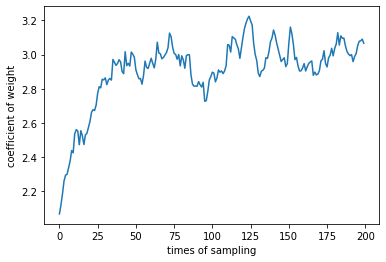

In [1176]:
plt.plot(weights_list)#重みの係数
plt.xlabel("times of sampling")
plt.ylabel("coefficient of weight")

Text(0, 0.5, 'intercept of weight')

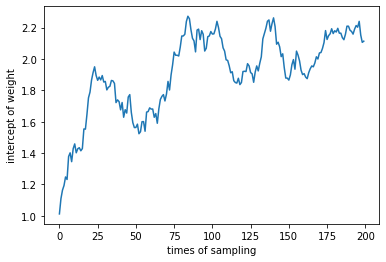

In [1177]:
plt.plot(intercept_list)#重みの切片
plt.xlabel("times of sampling")
plt.ylabel("intercept of weight")

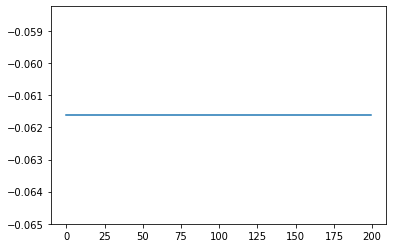

In [1178]:
plt.plot(mu_list)#平均

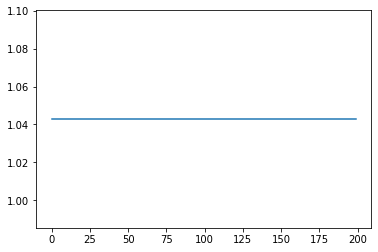

In [1179]:
plt.plot(sigma_list)#分散

In [1180]:
#最小二乗法の関数の確認

In [1181]:
LSM(np.array([1,2,3,4]).reshape(-1,1),np.array([2,3,4,5]).reshape(-1,1))#1,1隣正しい。

[1.0000000000000004, 0.9999999999999991]

In [1150]:
#weights_updateの確認(3,4)になれば正しい。
weights_update(true_test_df1)

[2.6391725611652492, 1.1012738231251196]

In [1097]:
#解析的に求めた条件付き分布と、サンプリングによって求めた条件付き分布の平均と分散の二乗和誤差を求める。
def SSE(df_calc,df_sample):
    mu_SSE = (df_calc["mu"]-df_sample["mu"]).sum()**2/2
    sigma_SSE = (df_calc["sigma"]-df_sample["sigma"]).sum()**2/2
    
    return mu_SSE,sigma_SSE

In [1098]:
condi_mus,condi_sigmas = conditional_paramators_2_node([1,1],test_df1,test_df1["pa"].mean(),test_df1["pa"].var(),test_df1["child"].var())
df_sample = pd.DataFrame(np.array([condi_mus,condi_sigmas]).T,columns=["mu","sigma"])#サンプリング
df_calc = conditional_distribution_df_2_node(test_df1,1,1)#解析解
SSE(df_calc,df_sample)

(6.43555509448071e-31, 0)

In [993]:
#二乗和誤差が十分小さく、正しい条件付き分布の平均と分散が得られている。

In [994]:
#サンプリングする手続きが正しいかどうか確認

In [995]:
samples = np.random.normal(2,3,10000)

In [996]:
#平均2,分散9になっているか。
print(samples.mean(),samples.var())#正しい

2.0315908501163 8.878816418545764
